In [2]:
# Core Libraries
import sqlite3
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score,
    classification_report, confusion_matrix,
    roc_curve, precision_recall_curve
)

Database connection and database information

In [3]:
DB_PATH = 'smart_home.db'

conn = sqlite3.connect(DB_PATH)

tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'", conn)
print("\nTables in database:")
print(tables)


Tables in database:
              name
0            homes
1          devices
2  sensor_readings
3           alerts


In [4]:
#List tables in smart home DB and number of records in each table

homes_df = pd.read_sql("SELECT * FROM homes", conn)
devices_df = pd.read_sql("SELECT * FROM devices", conn)
sensor_readings_df = pd.read_sql("SELECT * FROM sensor_readings", conn)
alerts_df = pd.read_sql("SELECT * FROM alerts", conn)


print(f"Homes: {len(homes_df)} records")
print(f"Devices: {len(devices_df)} records")
print(f"Sensor Readings: {len(sensor_readings_df)} records")
print(f"Alerts: {len(alerts_df)} records")

Homes: 200 records
Devices: 925 records
Sensor Readings: 222000 records
Alerts: 77 records


In [5]:
#Distribution of target variable

print(f"Distribution of device status:")
print(devices_df.status.value_counts())

Distribution of device status:
status
active     687
offline    238
Name: count, dtype: int64


Feature engineering using SQL

In [6]:
feature_engineering_sql = """
WITH
-- Get device age and basic device info
device_info AS (
    SELECT
        d.device_id,
        d.home_id,
        d.device_type,
        d.install_date,
        d.status,
        -- Calculate device age in days
        CAST(julianday('2025-11-16') - julianday(d.install_date) AS INTEGER) AS device_age_days,
        h.city,
        h.home_type
    FROM devices d
    JOIN homes h ON d.home_id = h.home_id
),

-- Sensor reading statistics per device
sensor_stats AS (
    SELECT
        device_id,
        COUNT(*) AS total_readings,
        COUNT(DISTINCT DATE(reading_datetime)) AS active_days,
        AVG(value_numeric) AS avg_numeric_value,
        MAX(value_numeric) AS max_numeric_value,
        MIN(value_numeric) AS min_numeric_value,
        -- Readings per day
        COUNT(*) * 1.0 / NULLIF(COUNT(DISTINCT DATE(reading_datetime)), 0) AS readings_per_day
    FROM sensor_readings
    GROUP BY device_id
),

-- Sensor reading patterns by metric type
metric_breakdown AS (
    SELECT
        device_id,
        SUM(CASE WHEN metric_type = 'temperature' THEN 1 ELSE 0 END) AS temp_readings,
        SUM(CASE WHEN metric_type = 'motion' THEN 1 ELSE 0 END) AS motion_readings,
        SUM(CASE WHEN metric_type = 'camera_motion' THEN 1 ELSE 0 END) AS camera_motion_readings,
        SUM(CASE WHEN metric_type = 'door_state' THEN 1 ELSE 0 END) AS door_state_readings,
        -- Average values by type
        AVG(CASE WHEN metric_type = 'temperature' THEN value_numeric END) AS avg_temperature,
        AVG(CASE WHEN metric_type = 'motion' THEN value_numeric END) AS avg_motion,
        -- Motion detection rate (for motion-based devices)
        AVG(CASE WHEN metric_type IN ('motion', 'camera_motion') AND value_numeric = 1 THEN 1.0 ELSE 0.0 END) AS motion_detection_rate
    FROM sensor_readings
    GROUP BY device_id
),

-- Alert statistics per device
alert_stats AS (
    SELECT
        device_id,
        COUNT(*) AS total_alerts,
        SUM(CASE WHEN severity = 'high' THEN 1 ELSE 0 END) AS high_severity_alerts,
        SUM(CASE WHEN severity = 'medium' THEN 1 ELSE 0 END) AS medium_severity_alerts,
        COUNT(DISTINCT DATE(alert_datetime)) AS days_with_alerts
    FROM alerts
    GROUP BY device_id
),

-- Home-level statistics (devices per home, offline rate in home)
home_stats AS (
    SELECT
        home_id,
        COUNT(*) AS devices_in_home,
        -- Offline rate in home: count of offline devices / total devices in home
        SUM(CASE WHEN status = 'offline' THEN 1.0 ELSE 0.0 END) / COUNT(*) AS home_offline_rate
    FROM devices
    GROUP BY home_id
),

-- Recent activity (last 7 days before data cutoff)
recent_activity AS (
    SELECT
        device_id,
        COUNT(*) AS recent_readings_7d,
        AVG(value_numeric) AS recent_avg_value_7d
    FROM sensor_readings
    WHERE reading_datetime >= datetime('2025-11-09')  -- Last 7 days
    GROUP BY device_id
)

-- Final feature set
SELECT
    di.device_id,
    di.device_type,
    di.device_age_days,
    di.city,
    di.home_type,

    -- Sensor reading features
    COALESCE(ss.total_readings, 0) AS total_readings,
    COALESCE(ss.active_days, 0) AS active_days,
    COALESCE(ss.avg_numeric_value, 0) AS avg_numeric_value,
    COALESCE(ss.max_numeric_value, 0) AS max_numeric_value,
    COALESCE(ss.min_numeric_value, 0) AS min_numeric_value,
    COALESCE(ss.readings_per_day, 0) AS readings_per_day,

    -- Metric-specific features
    COALESCE(mb.temp_readings, 0) AS temp_readings,
    COALESCE(mb.motion_readings, 0) AS motion_readings,
    COALESCE(mb.camera_motion_readings, 0) AS camera_motion_readings,
    COALESCE(mb.door_state_readings, 0) AS door_state_readings,
    COALESCE(mb.avg_temperature, 0) AS avg_temperature,
    COALESCE(mb.avg_motion, 0) AS avg_motion,
    COALESCE(mb.motion_detection_rate, 0) AS motion_detection_rate,

    -- Alert features
    COALESCE(als.total_alerts, 0) AS total_alerts,
    COALESCE(als.high_severity_alerts, 0) AS high_severity_alerts,
    COALESCE(als.medium_severity_alerts, 0) AS medium_severity_alerts,
    COALESCE(als.days_with_alerts, 0) AS days_with_alerts,

    -- Home-level features
    hs.devices_in_home,
    hs.home_offline_rate,

    -- Recent activity features
    COALESCE(ra.recent_readings_7d, 0) AS recent_readings_7d,
    COALESCE(ra.recent_avg_value_7d, 0) AS recent_avg_value_7d,

    -- Target variable
    CASE WHEN di.status = 'offline' THEN 1 ELSE 0 END AS device_failed

FROM device_info di
LEFT JOIN sensor_stats ss ON di.device_id = ss.device_id
LEFT JOIN metric_breakdown mb ON di.device_id = mb.device_id
LEFT JOIN alert_stats als ON di.device_id = als.device_id
LEFT JOIN home_stats hs ON di.home_id = hs.home_id
LEFT JOIN recent_activity ra ON di.device_id = ra.device_id
ORDER BY di.device_id;
"""

In [8]:
# Execute the feature engineering query
ml_data = pd.read_sql(feature_engineering_sql, conn)

print(f"Feature-engineered dataset: {ml_data.shape[0]} devices, {ml_data.shape[1]} columns")
ml_data.head()

Feature-engineered dataset: 925 devices, 27 columns


,device_id,device_type,device_age_days,city,home_type,total_readings,active_days,avg_numeric_value,max_numeric_value,min_numeric_value,...,motion_detection_rate,total_alerts,high_severity_alerts,medium_severity_alerts,days_with_alerts,devices_in_home,home_offline_rate,recent_readings_7d,recent_avg_value_7d,device_failed
0,1,motion_sensor,184,Seattle,condo,240,60,0.125000,1.0,0.0,...,0.125000,0,0,0,0,6,0.166667,32,0.15625,0
1,2,motion_sensor,451,Seattle,condo,240,60,0.125000,1.0,0.0,...,0.125000,0,0,0,0,6,0.166667,32,0.09375,0
2,3,camera,409,Seattle,condo,240,60,0.091667,1.0,0.0,...,0.091667,0,0,0,0,6,0.166667,32,0.03125,0
3,4,camera,296,Seattle,condo,240,60,0.070833,1.0,0.0,...,0.070833,0,0,0,0,6,0.166667,32,0.06250,0
4,5,thermostat,277,Seattle,condo,240,60,18.216250,27.5,12.5,...,0.000000,0,0,0,0,6,0.166667,32,19.00000,0


Explore new engineered ML dataset

In [9]:
# Dataset summary
print(ml_data.info())
print("\nDescriptive Statistics:")
ml_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   device_id               925 non-null    int64  
 1   device_type             925 non-null    object 
 2   device_age_days         925 non-null    int64  
 3   city                    925 non-null    object 
 4   home_type               925 non-null    object 
 5   total_readings          925 non-null    int64  
 6   active_days             925 non-null    int64  
 7   avg_numeric_value       925 non-null    float64
 8   max_numeric_value       925 non-null    float64
 9   min_numeric_value       925 non-null    float64
 10  readings_per_day        925 non-null    float64
 11  temp_readings           925 non-null    int64  
 12  motion_readings         925 non-null    int64  
 13  camera_motion_readings  925 non-null    int64  
 14  door_state_readings     925 non-null    in

,device_id,device_age_days,total_readings,active_days,avg_numeric_value,max_numeric_value,min_numeric_value,readings_per_day,temp_readings,motion_readings,...,motion_detection_rate,total_alerts,high_severity_alerts,medium_severity_alerts,days_with_alerts,devices_in_home,home_offline_rate,recent_readings_7d,recent_avg_value_7d,device_failed
count,925.000000,925.000000,925.0,925.0,925.000000,925.000000,925.000000,925.0,925.000000,925.000000,...,925.000000,925.000000,925.000000,925.00000,925.000000,925.000000,925.000000,925.0,925.000000,925.000000
mean,463.000000,366.822703,240.0,60.0,4.488719,7.003243,2.965622,4.0,56.821622,60.713514,...,0.055523,0.083243,0.043243,0.04000,0.082162,4.909189,0.257297,32.0,4.498554,0.257297
std,267.168798,205.652585,0.0,0.0,7.935015,11.402780,5.327642,0.0,102.077212,104.388184,...,0.060283,0.302569,0.213886,0.20681,0.297456,1.086304,0.208097,0.0,7.969276,0.437381
min,1.000000,2.000000,240.0,60.0,0.000000,0.000000,0.000000,4.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,3.000000,0.000000,32.0,0.000000,0.000000
25%,232.000000,183.000000,240.0,60.0,0.000000,0.000000,0.000000,4.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,4.000000,0.166667,32.0,0.000000,0.000000
50%,463.000000,365.000000,240.0,60.0,0.104167,1.000000,0.000000,4.0,0.000000,0.000000,...,0.050000,0.000000,0.000000,0.00000,0.000000,5.000000,0.200000,32.0,0.093750,0.000000
75%,694.000000,538.000000,240.0,60.0,0.175000,1.000000,0.000000,4.0,0.000000,240.000000,...,0.108333,0.000000,0.000000,0.00000,0.000000,6.000000,0.400000,32.0,0.250000,1.000000
max,925.000000,727.000000,240.0,60.0,19.701250,27.500000,12.700000,4.0,240.000000,240.000000,...,0.212500,2.000000,2.000000,2.00000,2.000000,6.000000,0.833333,32.0,21.643750,1.000000


Distribution of device status:
device_failed
0    687
1    238
Name: count, dtype: int64


[Text(0, 0, 'Active (0)'), Text(1, 0, 'Failed/Offline (1)')]

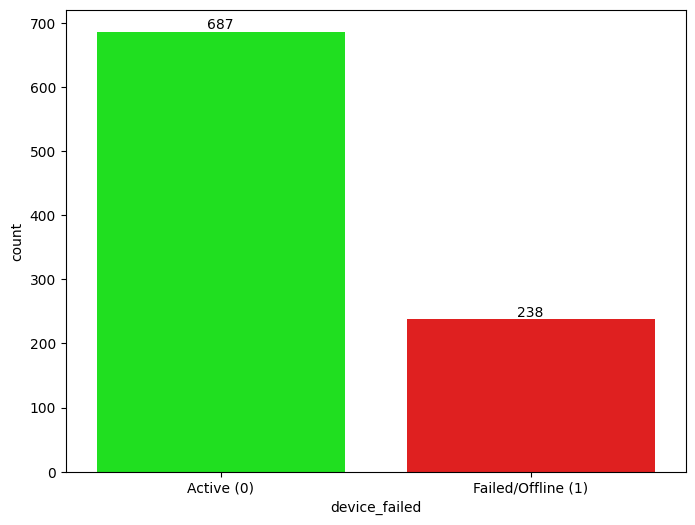

In [10]:
#Visualize distribution of target variable

print(f"Distribution of device status:")
print(ml_data.device_failed.value_counts())
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='device_failed', data=ml_data, palette=['#00FF00',"#FF0000"])
for container in ax.containers:
    ax.bar_label(container)
# Define new x axis labels
new_labels = ["Active (0)", "Failed/Offline (1)"]
# Set the new labels
ax.set_xticklabels(new_labels)


In [11]:
#Check for missing values
missing = 0
for col in ml_data.columns:
    missing_count = ml_data[col].isna().sum()
    missing += missing_count
    if missing_count > 0:
        print(f"Column '{col}' has {missing_count} missing values.")
if missing == 0:
  print(f"No missing values in dataset!")


No missing values in dataset!


Data Preprocessing

In [15]:
# Select only the 'category' columns
categorical_df = ml_data.select_dtypes(include=['object'])

print("\nCategorical Columns DataFrame:")
categorical_column_names = categorical_df.columns.tolist()
print("\nList of Categorical Column Names:", categorical_column_names)


Categorical Columns DataFrame:

List of Categorical Column Names: ['device_type', 'city', 'home_type']


In [16]:
# Show categorical columns
categorical_df = ml_data.select_dtypes(include=['object'])
print("\nCategorical Columns:")
for col in categorical_df.columns.tolist():
  print(f"{col}: {ml_data[col].unique()}")

# Create a copy for ML processing
df = ml_data.copy()

# Label encode categorical variables
label_encoders = {}
categorical_cols = categorical_df.columns.tolist()

for col in categorical_cols:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"{col} encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}")


Categorical Columns:
device_type: ['motion_sensor' 'camera' 'thermostat' 'door_lock']
city: ['Seattle' 'Boston' 'Austin' 'San Francisco' 'New York' 'Chicago']
home_type: ['condo' 'apartment' 'house']
device_type encoding: {'camera': np.int64(0), 'door_lock': np.int64(1), 'motion_sensor': np.int64(2), 'thermostat': np.int64(3)}
city encoding: {'Austin': np.int64(0), 'Boston': np.int64(1), 'Chicago': np.int64(2), 'New York': np.int64(3), 'San Francisco': np.int64(4), 'Seattle': np.int64(5)}
home_type encoding: {'apartment': np.int64(0), 'condo': np.int64(1), 'house': np.int64(2)}


In [17]:
# Define features and target
feature_columns = [
    'device_type_encoded', 'device_age_days', 'city_encoded', 'home_type_encoded',
    'total_readings', 'active_days', 'avg_numeric_value', 'max_numeric_value',
    'min_numeric_value', 'readings_per_day',
    'temp_readings', 'motion_readings', 'camera_motion_readings', 'door_state_readings',
    'avg_temperature', 'avg_motion', 'motion_detection_rate',
    'total_alerts', 'high_severity_alerts', 'medium_severity_alerts', 'days_with_alerts',
    'devices_in_home', 'home_offline_rate',
    'recent_readings_7d', 'recent_avg_value_7d'
]

X = df[feature_columns]
y = df['device_failed']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeatures used ({len(feature_columns)}):")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i}. {col}")

Feature matrix shape: (925, 25)
Target vector shape: (925,)

Features used (25):
  1. device_type_encoded
  2. device_age_days
  3. city_encoded
  4. home_type_encoded
  5. total_readings
  6. active_days
  7. avg_numeric_value
  8. max_numeric_value
  9. min_numeric_value
  10. readings_per_day
  11. temp_readings
  12. motion_readings
  13. camera_motion_readings
  14. door_state_readings
  15. avg_temperature
  16. avg_motion
  17. motion_detection_rate
  18. total_alerts
  19. high_severity_alerts
  20. medium_severity_alerts
  21. days_with_alerts
  22. devices_in_home
  23. home_offline_rate
  24. recent_readings_7d
  25. recent_avg_value_7d


In [18]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y #since we are dealing with imbalanced dataset, use stratify parameter to ensure resulting training and testing sets maintain the same proportion of classes as the original dataset
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"\nClass distribution in training set:")
print(y_train.value_counts())
print(f"\nClass distribution in testing set:")
print(y_test.value_counts())

Training set: 740 samples
Testing set: 185 samples

Class distribution in training set:
device_failed
0    550
1    190
Name: count, dtype: int64

Class distribution in testing set:
device_failed
0    137
1     48
Name: count, dtype: int64


In [19]:
# Scale features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")

Features scaled using StandardScaler


Model Training and Evaluation

Baseline model: Logistic Regression

In [20]:
# Baseline Model: Logistic Regression

print("BASELINE MODEL: Logistic Regression")


lr_model = LogisticRegression(random_state=599, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print(f"\nLogistic Regression Results:")
print(f"  Accuracy: {accuracy_lr:.4f}")
print(f"  AUC-ROC:  {auc_lr:.4f}")
print(f"  F1-Score: {f1_lr:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Active', 'Failed']))

BASELINE MODEL: Logistic Regression

Logistic Regression Results:
  Accuracy: 0.8000
  AUC-ROC:  0.8148
  F1-Score: 0.5542

Classification Report:
              precision    recall  f1-score   support

      Active       0.83      0.91      0.87       137
      Failed       0.66      0.48      0.55        48

    accuracy                           0.80       185
   macro avg       0.75      0.70      0.71       185
weighted avg       0.79      0.80      0.79       185



Advanced Model 1: Random Forest Classifier

In [21]:
# Advanced Model 1: Random Forest Classifier
print("ADVANCED MODEL 1: Random Forest Classifier")

param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [3, 5, 10],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestClassifier(
    random_state=599,
    n_jobs=-1
)

# Initialize StratifiedKFold with 5 splits
# Stratified K-Fold cross-validation used with GridSearchCV to ensures each fold maintains the same class distribution as the original dataset
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Choose best model via cross-validation
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=skf, # Use Stratified K-Fold
    scoring='roc_auc',
    n_jobs=-1)
grid_search.fit(X_train, y_train) #Note: RF doesnt require scaling
print("Best Parameters:", grid_search.best_params_)
print(f"Best cross-validation AUC-ROC: {grid_search.best_score_:.4f}")
best_rf_model = grid_search.best_estimator_

# Predictions
y_pred_rf = best_rf_model.predict(X_test)
y_pred_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]

# Metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print(f"\nRandom Forest Results:")
print(f"  Accuracy: {accuracy_rf:.4f}")
print(f"  AUC-ROC:  {auc_rf:.4f}")
print(f"  F1-Score: {f1_rf:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Active', 'Failed']))

ADVANCED MODEL 1: Random Forest Classifier
Best Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation AUC-ROC: 0.7600

Random Forest Results:
  Accuracy: 0.7297
  AUC-ROC:  0.7797
  F1-Score: 0.0741

Classification Report:
              precision    recall  f1-score   support

      Active       0.74      0.97      0.84       137
      Failed       0.33      0.04      0.07        48

    accuracy                           0.73       185
   macro avg       0.54      0.51      0.46       185
weighted avg       0.64      0.73      0.64       185



Advanced Model 2: Gradient Boosting Classifier

In [22]:
# Advanced Model 2: Gradient Boosting Classifier

print("ADVANCED MODEL 2: Gradient Boosting Classifier")

param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gb_model = GradientBoostingClassifier(
    random_state=599
)

# Initialize StratifiedKFold with 5 splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Choose best model via cross-validation
grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    cv=skf, # Use Stratified K-Fold
    scoring='roc_auc',
    n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print(f"Best cross-validation AUC-ROC: {grid_search.best_score_:.4f}")
best_gb_model = grid_search.best_estimator_

# Predictions
y_pred_gb = best_gb_model.predict(X_test)
y_pred_proba_gb = best_gb_model.predict_proba(X_test)[:, 1]

# Metrics
accuracy_gb = accuracy_score(y_test, y_pred_gb)
auc_gb = roc_auc_score(y_test, y_pred_proba_gb)
f1_gb = f1_score(y_test, y_pred_gb)

print(f"\nGradient Boosting Results:")
print(f"  Accuracy: {accuracy_gb:.4f}")
print(f"  AUC-ROC:  {auc_gb:.4f}")
print(f"  F1-Score: {f1_gb:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_gb, target_names=['Active', 'Failed']))

ADVANCED MODEL 2: Gradient Boosting Classifier
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation AUC-ROC: 0.7779

Gradient Boosting Results:
  Accuracy: 0.7676
  AUC-ROC:  0.7889
  F1-Score: 0.3944

Classification Report:
              precision    recall  f1-score   support

      Active       0.79      0.93      0.86       137
      Failed       0.61      0.29      0.39        48

    accuracy                           0.77       185
   macro avg       0.70      0.61      0.63       185
weighted avg       0.74      0.77      0.74       185



In [23]:
# Create comparison dataframe
model_comparison = pd.DataFrame({
    'Model': ['Logistic Regression (Baseline)', 'Random Forest', 'Gradient Boosting'],
    'Accuracy': [accuracy_lr, accuracy_rf, accuracy_gb],
    'AUC-ROC': [auc_lr, auc_rf, auc_gb],
    'F1-Score': [f1_lr, f1_rf, f1_gb]
})


print("MODEL COMPARISON SUMMARY")

print(model_comparison.to_string(index=False))

# Identify best model
best_model_idx = model_comparison['AUC-ROC'].idxmax()
best_model = model_comparison.loc[best_model_idx, 'Model']
print(f"\n*** Best Model (by AUC-ROC): {best_model} ***")

MODEL COMPARISON SUMMARY
                         Model  Accuracy  AUC-ROC  F1-Score
Logistic Regression (Baseline)  0.800000 0.814781  0.554217
                 Random Forest  0.729730 0.779653  0.074074
             Gradient Boosting  0.767568 0.788929  0.394366

*** Best Model (by AUC-ROC): Logistic Regression (Baseline) ***


Feature Importance Analysis

In [24]:
# Feature importance from Random Forest
rf_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Random Forest Feature Importance:")
print(rf_importance.head(15).to_string(index=False))

Random Forest Feature Importance:
               Feature  Importance
     home_offline_rate    0.489162
       device_age_days    0.133693
   recent_avg_value_7d    0.063697
     avg_numeric_value    0.054032
          city_encoded    0.040027
 motion_detection_rate    0.035322
       avg_temperature    0.030297
            avg_motion    0.027505
     min_numeric_value    0.024720
       devices_in_home    0.024449
     home_type_encoded    0.018552
     max_numeric_value    0.010134
   device_type_encoded    0.009957
medium_severity_alerts    0.007139
      days_with_alerts    0.007092


In [25]:
# Feature importance from Gradient Boosting
gb_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': best_gb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Gradient Boosting Feature Importance:")
print(gb_importance.head(15).to_string(index=False))

Gradient Boosting Feature Importance:
               Feature  Importance
     home_offline_rate    0.689276
       device_age_days    0.161709
   recent_avg_value_7d    0.067864
     avg_numeric_value    0.023360
 motion_detection_rate    0.012060
     min_numeric_value    0.011566
          city_encoded    0.006925
     max_numeric_value    0.004473
   door_state_readings    0.003712
      days_with_alerts    0.003244
medium_severity_alerts    0.002959
            avg_motion    0.002620
  high_severity_alerts    0.002246
       devices_in_home    0.002028
       avg_temperature    0.001868


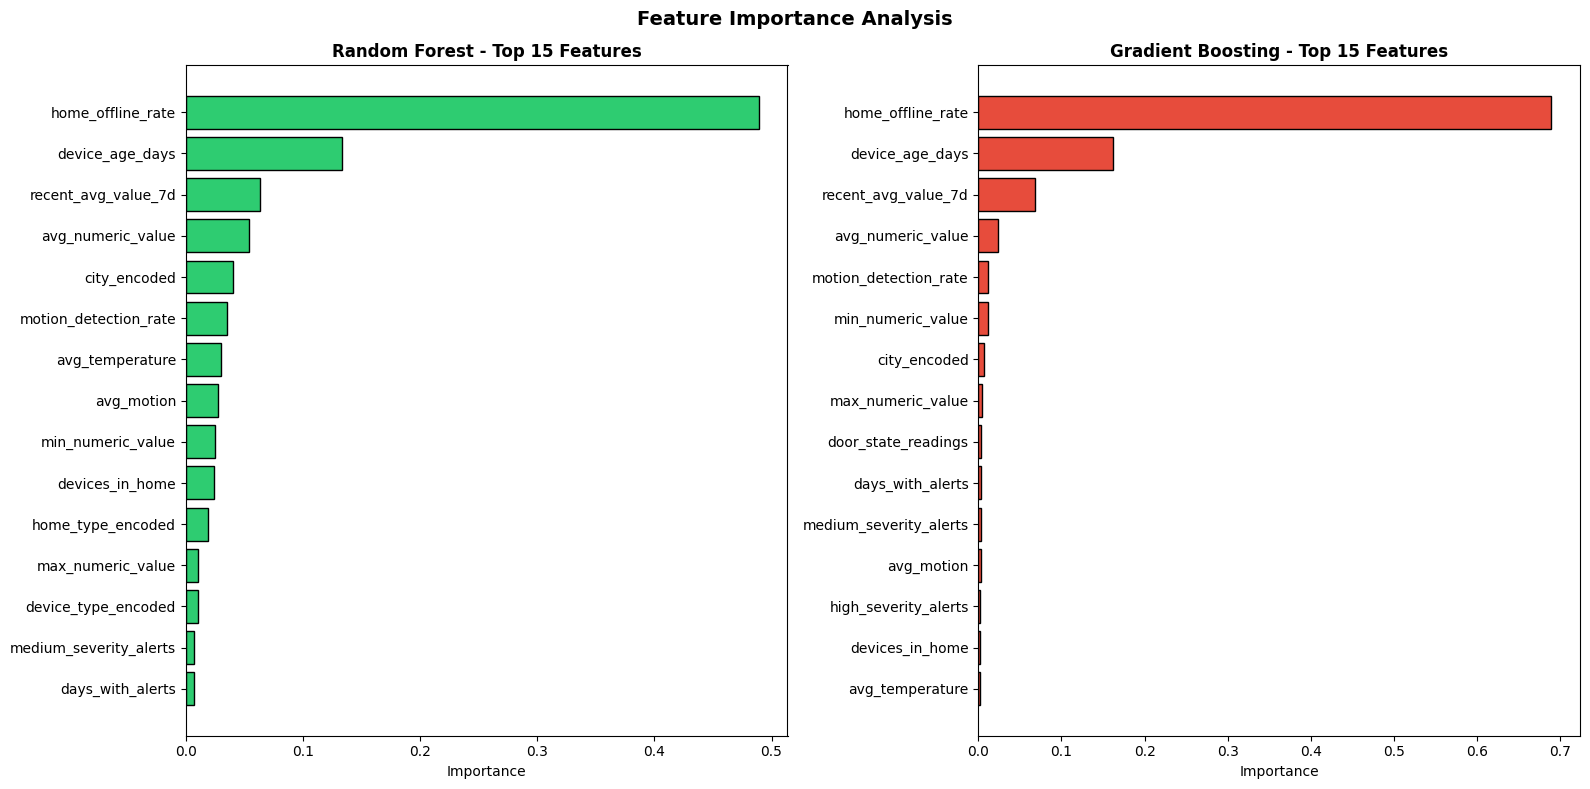

In [26]:
# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Random Forest Feature Importance
top_n = 15
rf_top = rf_importance.head(top_n)
axes[0].barh(rf_top['Feature'], rf_top['Importance'], color='#2ecc71', edgecolor='black')
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest - Top 15 Features', fontweight='bold')
axes[0].invert_yaxis()

# Gradient Boosting Feature Importance
gb_top = gb_importance.head(top_n)
axes[1].barh(gb_top['Feature'], gb_top['Importance'], color='#e74c3c', edgecolor='black')
axes[1].set_xlabel('Importance')
axes[1].set_title('Gradient Boosting - Top 15 Features', fontweight='bold')
axes[1].invert_yaxis()

plt.suptitle('Feature Importance Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

In [27]:
# Logistic Regression Coefficients (for interpretability)
# Determine the significance of a feature in logistic regression by looking at size of the coefficients (β). Features with higher absolute coefficient values are deemed more significant
lr_coef = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': lr_model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print("Logistic Regression Coefficients (Top 15 by absolute value):")
print(lr_coef.head(15).to_string(index=False))

Logistic Regression Coefficients (Top 15 by absolute value):
               Feature  Coefficient
     home_offline_rate     1.204541
 motion_detection_rate    -0.635148
   recent_avg_value_7d    -0.425420
   door_state_readings    -0.332579
      days_with_alerts     0.331075
       motion_readings     0.261942
            avg_motion     0.144245
  high_severity_alerts    -0.140451
          total_alerts    -0.136589
camera_motion_readings     0.108258
       devices_in_home     0.102503
       device_age_days     0.095076
       avg_temperature     0.076151
     avg_numeric_value     0.071651
medium_severity_alerts    -0.059272


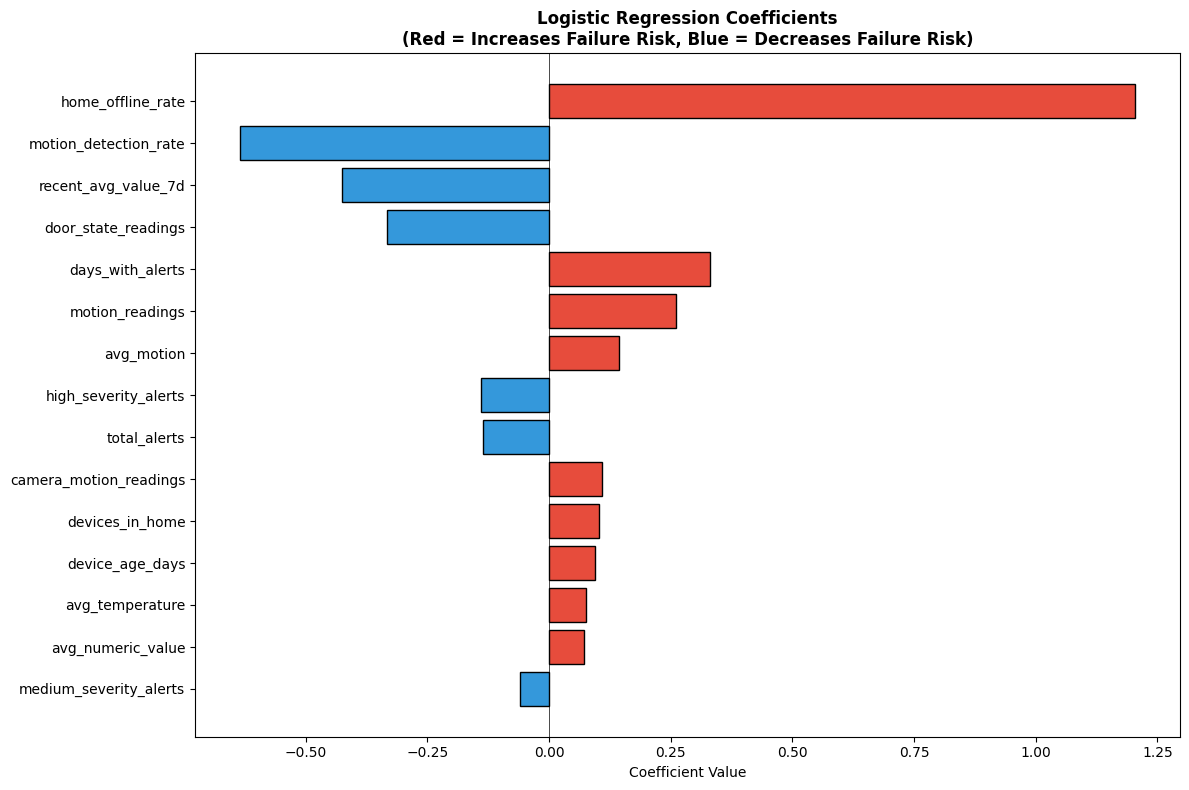

In [28]:
# Visualize Logistic Regression Coefficients
# Positive Coefficient: Indicates that an increase in the predictor variable increases the log odds of device failure.
# Negative Coefficient: Indicates that an increase in the predictor variable decreases the log odds of device failure.
fig, ax = plt.subplots(figsize=(12, 8))

lr_top = lr_coef.head(15)
colors = ['#e74c3c' if x > 0 else '#3498db' for x in lr_top['Coefficient']]
ax.barh(lr_top['Feature'], lr_top['Coefficient'], color=colors, edgecolor='black')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('Coefficient Value')
ax.set_title('Logistic Regression Coefficients\n(Red = Increases Failure Risk, Blue = Decreases Failure Risk)',
             fontweight='bold')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('lr_coefficients.png', dpi=150, bbox_inches='tight')
plt.show()

Plotly Dashboard of Key Insights from Dataset

In [29]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import io
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Connect to the SQLite database
conn = sqlite3.connect("smart_home.db")

# Query 1: Alerts by City
query = '''
SELECT h.city, COUNT(a.alert_id) AS TotalAlerts
FROM homes h
LEFT JOIN devices d ON h.home_id = d.home_id
LEFT JOIN alerts a ON a.device_id = d.device_id
GROUP BY h.city
ORDER BY TotalAlerts DESC;
'''
df_city = pd.read_sql_query(query, conn)

# Query 2: Alerts by Home Type
query = '''
SELECT h.home_type, COUNT(a.alert_id) AS TotalAlerts
FROM homes h
LEFT JOIN devices d ON h.home_id = d.home_id
LEFT JOIN alerts a ON a.device_id = d.device_id
GROUP BY h.home_type
ORDER BY TotalAlerts DESC;
'''
df_home = pd.read_sql_query(query, conn)

# Query 3: Device installation per Month
query = '''
SELECT device_id, STRFTIME('%m', install_date) as InstallMonth
  FROM devices
  ORDER BY InstallMonth;
'''
df_install = pd.read_sql_query(query, conn)

# Query 4: Day of Week Alerts
query = '''
SELECT CASE CAST(strftime('%w', alert_datetime) AS INTEGER)
    WHEN 0 THEN 'Sunday'
    WHEN 1 THEN 'Monday'
    WHEN 2 THEN 'Tuesday'
    WHEN 3 THEN 'Wednesday'
    WHEN 4 THEN 'Thursday'
    WHEN 5 THEN 'Friday'
    ELSE 'Saturday'
  END AS DayOfWeek, COUNT(a.alert_id) AS TotalAlerts
FROM alerts a
GROUP BY DayOfWeek
ORDER BY
  strftime('%w', alert_datetime) ASC;
'''
df_dayofweek = pd.read_sql_query(query, conn)

# Query 5: Treemap
query = '''
SELECT h.city, a.severity, COUNT(a.alert_id) AS TotalAlerts
FROM alerts a
LEFT JOIN devices d ON a.device_id = d.device_id
LEFT JOIN homes h ON d.home_id = h.home_id
GROUP BY h.city, a.severity
ORDER BY h.city, a.severity;
'''
df_tree = pd.read_sql_query(query, conn)

# Query 6: Daily alerts
query = '''
SELECT strftime('%Y-%m-%d', alert_datetime) as Date, COUNT(a.alert_id) AS TotalAlerts
FROM alerts a
  GROUP BY DATE
  ORDER BY Date;
'''
df_daily = pd.read_sql_query(query, conn)


# Build dashboard
fig = make_subplots(
    rows=3, cols=2, #with 3 rows and 2 columns for total 3x2 = 6 plots
    specs=[
        [{"type": "bar"}, {"type": "bar"}], # first row has 2 bar plots
        [{"type": "xy"}, {"type": "xy"}], #second row has histogram / line plots
        [{"type": "domain"}, {"type": "xy"}]  #third row has treemap (domain) on left
    ],
    # specify all plot's titles
    subplot_titles=[
        "Intrusion Alerts by City",
        "Intrusion Alerts by Home Type",
        "Device Installations by Month",
        "Day of Week Alerts Trend",
        "Alerts by City & Severity",
        "Daily Alerts Trend"
    ]
)

# Chart 1: Bar (City)
fig.add_trace(
    go.Bar(x=df_city["TotalAlerts"], y=df_city["city"], orientation="h"),
    row=1, col=1
)
# Set axis labels
fig.update_xaxes(title_text="No. of Alerts", row=1, col=1)
fig.update_yaxes(title_text="City", row=1, col=1)

# Chart 2: Bar (Home Type)
fig.add_trace(
    go.Bar(x=df_home["TotalAlerts"], y=df_home["home_type"], orientation="h"),
    row=1, col=2
)
# Set axis labels
fig.update_xaxes(title_text="No. of Alerts", row=1, col=2)
fig.update_yaxes(title_text="Home Type", row=1, col=2)

# Chart 3: Histogram (Monthly Installations)
fig.add_trace(
    go.Histogram(x=df_install["InstallMonth"]),
    row=2, col=1
)
# Set axis labels
fig.update_xaxes(title_text="Install Month", row=2, col=1)
fig.update_yaxes(title_text="Number of Devices", row=2, col=1)

# Chart 4: Line (Day of Week Alerts)
fig.add_trace(
    go.Scatter(x=df_dayofweek["DayOfWeek"], y=df_dayofweek["TotalAlerts"], mode="lines"),
    row=2, col=2
)
# Set axis labels
fig.update_xaxes(title_text="Day", row=2, col=2)
fig.update_yaxes(title_text="Total No. of Alerts", row=2, col=2)

# Chart 5: Treemap
tree = px.treemap(
    df_tree,
    path=["city", "severity"],
    values="TotalAlerts",
    color="TotalAlerts"
)

fig.add_trace(tree.data[0], row=3, col=1)
fig.update_layout(coloraxis=dict(colorscale='Viridis_r')) #color scheme for treemap

# Format layout of dashboard
fig.update_layout(
    height=1100,
    width=1200,
    title_x=0.5,
    margin=dict(t=80, l=20, r=20, b=20),
    title={
        'text': "Smart Home IoT Dashboard", # Set dashboard title
        'font': {'size': 20}  # Set the desired font size here
    },
    showlegend=False,  # Remove legend
    # Adjust treemap colorscale to show only right next to treemap
    coloraxis_colorbar=dict(
          len=0.23,           # Reduce length of colorscale
          thickness=15,      # Set thickness
          xanchor="right",
          x=1,
          yanchor='bottom',
          y=0.1
      )
)

fig.update_layout(coloraxis_colorbar_x=0.5, coloraxis_colorbar_y=0) #set position of colorscale right beside treemap
fig.update_layout(coloraxis_colorbar_orientation="v")

# Chart 6: Line (Daily Alerts)
fig.add_trace(
    go.Scatter(x=df_daily["Date"], y=df_daily["TotalAlerts"], mode="lines"),
    row=3, col=2
)
# Set axis labels
fig.update_xaxes(title_text="Date", row=3, col=2)
fig.update_yaxes(title_text="Total No. of Alerts", row=3, col=2)

fig.show()